# Climate Analysis and Exploration
###  Now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on the new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

In [18]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, MetaData, inspect, func
from sqlalchemy import Column, Integer, String, Numeric, Text, Float
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import cast, Integer
from flask import Flask, jsonify

In [19]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [20]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [21]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [22]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR(255)
date VARCHAR(255)
prcp FLOAT
tobs INTEGER


In [23]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station VARCHAR(255)
name VARCHAR(255)
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [24]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.Measurement
Station = Base.classes.Station
Base.classes.keys()

['Measurement', 'Station']

In [25]:
session = Session(bind=engine)

## Precipitation Analysis

### Design a query to retrieve the last 12 months of precipitation data.

In [26]:
precipitation = session.query(Measurement.date, func.avg(Measurement.prcp)).\
    filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
    group_by(Measurement.date).all()

prcp_df = pd.DataFrame(precipitation, columns=['date', 'precipitation'])

### Visualize the result using the matplotlib plot and bar methods.

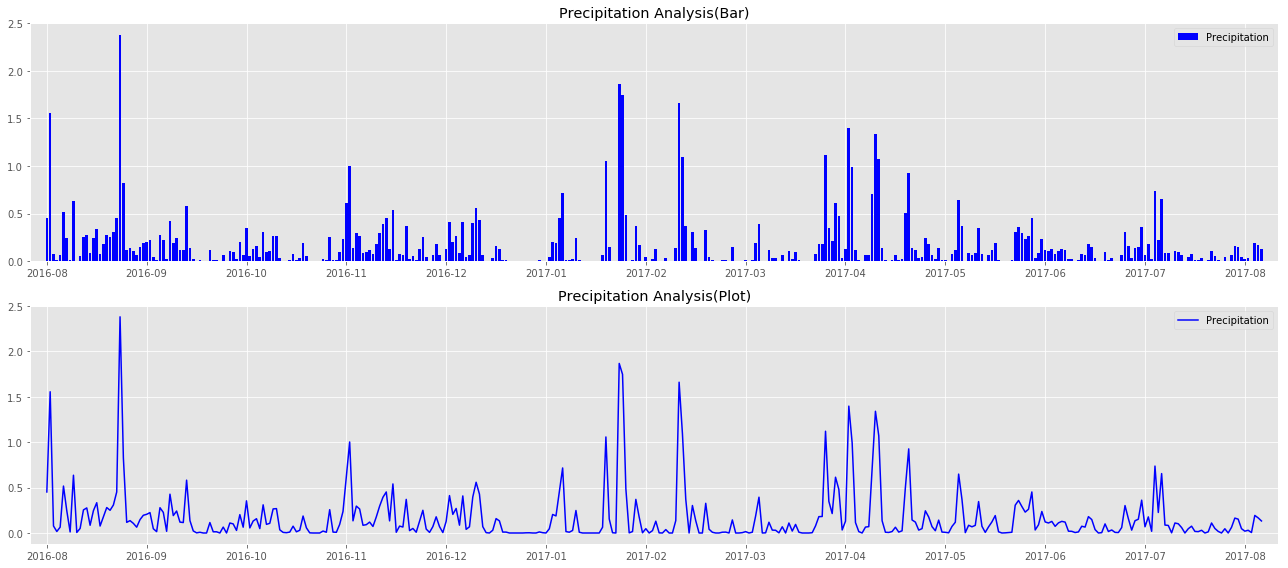

In [27]:
plt.style.use('ggplot')
x_label = ['2016-08', '2016-09', '2016-10', '2016-11', '2016-12', 
          '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', 
          '2017-06', '2017-07', '2017-08', ]
x_value= np.arange(len(prcp_df['date']))
fig, ax = plt.subplots(nrows=2,figsize=(18, 8))
major_ticks = np.arange(0, 390, 30)
ax[0].bar(x_value, prcp_df['precipitation'], color='blue')
ax[0].set_xticks(major_ticks)
ax[0].set_xticklabels(x_label)
ax[0].set_xlim(-5,370)
ax[0].legend(['Precipitation'], loc=0)
ax[0].set_title('Precipitation Analysis(Bar)')
ax[1].plot(x_value, prcp_df['precipitation'], color='blue')
ax[1].set_xticks(major_ticks)
ax[1].set_xticklabels(x_label)
ax[1].set_xlim(-5,370)
ax[1].legend(['Precipitation'], loc=0)
ax[1].set_title('Precipitation Analysis(Plot)')
plt.tight_layout()
plt.savefig("precipitation_analysis.png", bbox_inches='tight')
plt.show()

## Station Analysis

### Design a query to calculate the total number of stations.
- ### 9 stations

In [28]:
station = session.query(func.count(Station.station)).all()
station_count = station[0][0]
station_count

9

### Design a query to find the most active stations. Which station has the highest number of observations?
- ### WAIHEE 837.5, HI US

In [29]:
observation_count = session.query(Station.name, func.count(Measurement.station)).\
                    filter(Station.station == Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
observation_count

[('WAIHEE 837.5, HI US', 2772),
 ('KANEOHE 838.1, HI US', 2696),
 ('WAIKIKI 717.2, HI US', 2685),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 2572),
 ('MANOA LYON ARBO 785.2, HI US', 2484),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 1937),
 ('HONOLULU OBSERVATORY 702.2, HI US', 1932),
 ('PEARL CITY, HI US', 683),
 ('UPPER WAHIAWA 874.3, HI US', 342)]

### Design a query to retrieve the last 12 months of temperature observation data (tobs). Filter by the station with the highest number of observations. Plot the result as histogram.

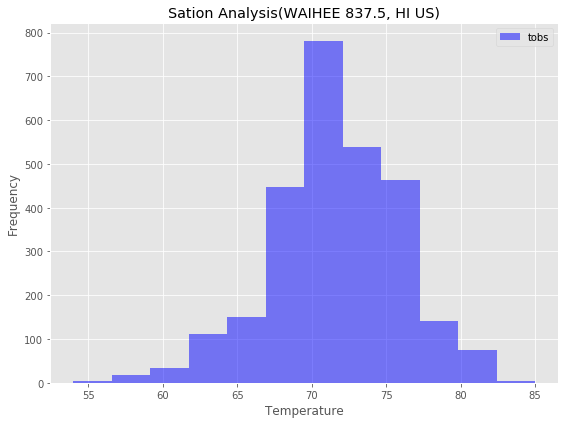

In [30]:
temperature = session.query(Measurement.tobs).\
              filter(Station.station == Measurement.station).\
              filter(Station.name == 'WAIHEE 837.5, HI US').all()
        
tobs_df = pd.DataFrame(temperature, columns=['tobs'])

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(tobs_df['tobs'], bins=12, color='blue', alpha=0.5)
ax.legend(['tobs'])
ax.set_title('Sation Analysis(WAIHEE 837.5, HI US)')
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig("station_analysis.png", bbox_inches='tight')
plt.show()

## Temperature Analysis

### Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.

In [31]:
def calc_temps(start_date, end_date):
    min_temp = session.query(func.min(Measurement.tobs)).\
               filter(Measurement.date.between(start_date, end_date)).all()
    max_temp = session.query(func.max(Measurement.tobs)).\
               filter(Measurement.date.between(start_date, end_date)).all()
    avg_temp = session.query(func.avg(Measurement.tobs)).\
               filter(Measurement.date.between(start_date, end_date)).all()
    result = min_temp, max_temp, avg_temp
    return list(np.ravel(result))

### Use the calc_temps function to calculate the min, avg, and max temperatures for a trip, Plot the min, avg, and max temperature as a bar chart.

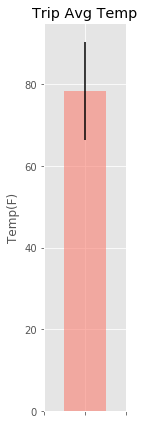

In [32]:
start_date = dt.datetime(2017, 7, 17)
end_date = dt.datetime(2017, 7, 27)
temp_data = calc_temps(start_date, end_date)
Max = temp_data[0]
Min = temp_data[1]
Avg = temp_data[2]

fig, ax = plt.subplots(figsize=(2,6))
ax.bar(x=1, height= Avg, width=2, left=2, yerr=Max-Min, color='salmon', alpha=0.6)
ax.set_xlim(0,4)
ax.set_xticklabels('')
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp(F)')
plt.tight_layout()
plt.savefig("temperture_analysis.png", bbox_inches='tight')
plt.show()

## Optional Recommended Analysis

### Calcualte the rainfall per weather, station using the previous year's matching dates.

In [33]:
rainfall_summer = session.query(Station.name, func.sum(Measurement.tobs)).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date.between('2016-06-01', '2016-08-31')).\
    group_by(Station.name).all()


rainfall_fall = session.query(Station.name, func.sum(Measurement.tobs)).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date.between('2016-09-01', '2016-11-30')).\
    group_by(Station.name).all()


rainfall_winter = session.query(Station.name, func.sum(Measurement.tobs)).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date.between('2016-12-01', '2017-02-29')).\
    group_by(Station.name).all()


rainfall_spring = session.query(Station.name, func.sum(Measurement.tobs)).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date.between('2017-03-01', '2017-05-31')).\
    group_by(Station.name).all()

print("Rainfall in Summer: {}\n\nRainfall in Fall: {}\n\nRainfall in Winter: {}\n\nRainfall in Spring: {}".\
      format(rainfall_summer, rainfall_fall, rainfall_winter, rainfall_spring))

Rainfall in Summer: [('KANEOHE 838.1, HI US', 6945), ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 5202), ('MANOA LYON ARBO 785.2, HI US', 5426), ('PEARL CITY, HI US', 1260), ('WAIHEE 837.5, HI US', 7012), ('WAIKIKI 717.2, HI US', 7189), ('WAIMANALO EXPERIMENTAL FARM, HI US', 6637)]

Rainfall in Fall: [('KANEOHE 838.1, HI US', 6897), ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 5183), ('MANOA LYON ARBO 785.2, HI US', 6433), ('PEARL CITY, HI US', 851), ('WAIHEE 837.5, HI US', 6912), ('WAIKIKI 717.2, HI US', 6865), ('WAIMANALO EXPERIMENTAL FARM, HI US', 6818)]

Rainfall in Winter: [('KANEOHE 838.1, HI US', 6240), ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 4939), ('MANOA LYON ARBO 785.2, HI US', 5740), ('PEARL CITY, HI US', 1447), ('WAIHEE 837.5, HI US', 6211), ('WAIKIKI 717.2, HI US', 6218), ('WAIMANALO EXPERIMENTAL FARM, HI US', 4965)]

Rainfall in Spring: [('KANEOHE 838.1, HI US', 6640), ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 4818), ('MANOA LYON ARBO 785.2, HI US', 5517), ('PEARL CITY, 

### Create a function called daily_normals that will calculate the daily normals for a specific date. 

In [34]:
def daily_normals(date):
    M_D = date.split('-')
    TMIN = session.query(func.min(Measurement.tobs)).\
           filter(func.strftime("%m", Measurement.date) == M_D[0]).\
           filter(func.strftime("%d", Measurement.date) == M_D[1]).all()
    TMAX = session.query(func.max(Measurement.tobs)).\
           filter(func.strftime("%m", Measurement.date) == M_D[0]).\
           filter(func.strftime("%d", Measurement.date) == M_D[1]).all()
    TAVG = session.query(func.avg(Measurement.tobs)).\
           filter(func.strftime("%m", Measurement.date) == M_D[0]).\
           filter(func.strftime("%d", Measurement.date) == M_D[1]).all()
    result = TMIN, TMAX, TAVG
    temp_list = list(np.ravel(result))
    
    return temp_list

### Use Pandas to create dataframe and plot an area plot for the daily normals.

In [36]:
trip = ["07-"+str(i) for i in range(17, 31)]
trip_data = [daily_normals(j) for j in trip]

trip_df = pd.DataFrame(trip_data, columns=["tmin", "tmax", "tavg"])
trip_df['Trip Date'] = trip
trip_df.set_index('Trip Date', inplace=True)
trip_df

,tmin,tmax,tavg
Trip Date,,,
07-17,70.0,83.0,76.392157
07-18,72.0,83.0,76.627451
07-19,68.0,83.0,75.830189
07-20,69.0,82.0,75.326923
07-21,69.0,83.0,76.979592
07-22,69.0,81.0,75.755102
07-23,70.0,82.0,75.940000
07-24,69.0,81.0,76.400000
07-25,67.0,84.0,76.941176


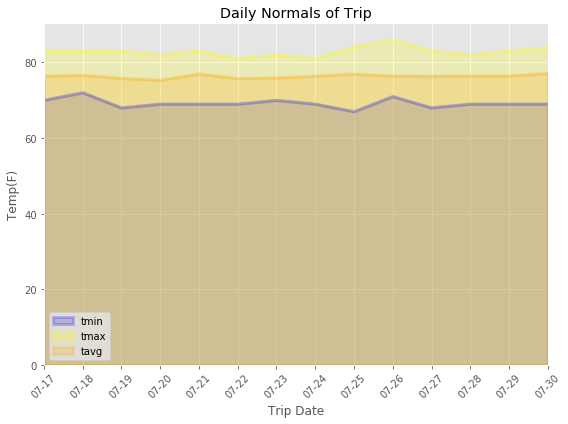

In [37]:
trip_plot = trip_df.plot(kind='area', stacked=False, alpha=0.2,
                         color=['blue', 'yellow', 'orange'], 
                         figsize=(8, 6), lw=3)
trip_plot.set_title('Daily Normals of Trip')
trip_plot.set_ylabel('Temp(F)')
trip_plot.set_xticks(np.arange(0, len(trip)))
trip_plot.set_xticklabels(labels=trip, rotation=45)
plt.tight_layout()
plt.savefig("daily_normal_analysis.png", bbox_inches='tight')
plt.show()

## Climate App
###  Design a Flask api based on the queries that I have just developed.

In [ ]:
app = Flask(__name__)

@app.route("/api/v1.0/precipitation")
def precipitation():
    """Query for the dates and temperature observations from the last year."""
    precipitation = session.query(Measurement.date, func.avg(Measurement.tobs)).\
    filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
    group_by(Measurement.date).all()
    tobs_list = []
    for tobs in precipitation:
        tobs_dict = {}
        tobs_dict[tobs[0]] = round(tobs[1])
        tobs_list.append(tobs_dict)

    return jsonify(tobs_list)

@app.route("/api/v1.0/stations")
def stations():
    """Return a json list of stations from the dataset."""
    stations = session.query(Station.name).all()
    station_list = list(np.ravel(stations))
    
    return jsonify(station_list)

@app.route("/api/v1.0/tobs")
def tobs():
    """Return a json list of Temperature Observations (tobs) for the previous year."""
    tobs = session.query(Measurement.tobs).\
    filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()
    
    return jsonify(tobs)

@app.route("/api/v1.0/<start>")
def start_temp(start):
    """Return a json list of the minimum temperature, the average temperature, 
    and the max temperature for a given start."""
    TMIN = session.query(func.min(Measurement.tobs)).\
           filter(Measurement.date == start).all()
    TMAX = session.query(func.max(Measurement.tobs)).\
           filter(Measurement.date == start).all()
    TAVG = session.query(func.avg(Measurement.tobs)).\
           filter(Measurement.date == start).all()
    result = TMIN, TMAX, TAVG
    temp_list = list(np.ravel(result))
    temp_dist = {'TMIN':temp_list[0], 'TMAX':temp_list[1], 'TAVG':temp_list[2]}
    
    return jsonify(temp_dist)

@app.route("/api/v1.0/<start>/<end>")
def start_end_temp(start, end):
    """Return a json list of the minimum temperature, the average temperature,
    and the max temperature for a given start-end range."""
    TMIN = session.query(func.min(Measurement.tobs)).\
           filter(Measurement.date.between(start, end)).all()
    TMAX = session.query(func.max(Measurement.tobs)).\
           filter(Measurement.date.between(start, end)).all()
    TAVG = session.query(func.avg(Measurement.tobs)).\
           filter(Measurement.date.between(start, end)).all()
    result = TMIN, TMAX, TAVG
    temp_list = list(np.ravel(result))
    temp_dist = {'TMIN':temp_list[0], 'TMAX':temp_list[1], 'TAVG':temp_list[2]}
    
    return jsonify(temp_dist)

if __name__ == "__main__":
    app.run(debug=True)